## Imports

In [2]:
import os
import pandas as pd
import numpy as np
from keras import layers
import matplotlib.pyplot as plt
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from geopy.geocoders import Nominatim
import cv2
from sklearn.metrics import f1_score
np.random.seed(1)

ImportError: DLL load failed while importing _openmp_helpers: No hay suficientes recursos de memoria disponibles para procesar este comando.

In [2]:
data_path = 'C:/Users/diego/PycharmProjects/NSVM_nuwe_hackaton/train_test_data'

train_path = f'{data_path}/train.csv'
train_states_path = f'{data_path}/train_states.csv'
test_path = f'{data_path}/test.csv'
train_image_path = f'{data_path}/train'
test_image_path = f'{data_path}/test'

In [3]:
# Read the train.csv file
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.head()

,label,latitude,longitude,year,example_path
0,0,-2.051853,111.826093,2001,train_test_data/train/1297.png
1,2,-1.989349,105.309496,2013,train_test_data/train/1199.png
2,0,1.223256,100.702217,2014,train_test_data/train/1348.png
3,0,-2.342948,103.890226,2008,train_test_data/train/2214.png
4,0,-0.126555,101.758175,2011,train_test_data/train/2220.png


In [8]:
geolocator = Nominatim(user_agent="NSVM_nuwe")

# Function to get the country name from the latitude and longitude values from the dataset train
def get_country_state(lat, long):
    location = geolocator.reverse(str(lat) + ', ' + str(long))
    address = location.raw['address']
    country = address.get('country', '')
    state = address.get('state', '')
    print(country, state)
    return country, state

# Apply the function to the train dataframe
train_df['country'], train_df['state'] = zip(*train_df.apply(lambda x: get_country_state(x['latitude'], x['longitude']), axis=1))

print(train_df['country'].value_counts())
print(train_df['country'].unique())


Indonesia Kalimantan Tengah
Indonesia Kepulauan Bangka Belitung
Indonesia Riau
Indonesia Sumatera Selatan
Indonesia Riau
Indonesia Jambi
Indonesia Riau
Indonesia Kalimantan Barat
Indonesia Riau
Indonesia Kalimantan Barat
Indonesia Sumatera Utara
Indonesia Sulawesi Selatan
Indonesia Sumatera Utara
Indonesia Jambi
Indonesia Riau
Indonesia Riau
Indonesia Riau
Indonesia Sumatera Barat
Indonesia Sulawesi Selatan
Indonesia Sulawesi Tenggara
Indonesia Kalimantan Barat
Indonesia Riau
Indonesia Aceh
Indonesia Aceh
Indonesia Sulawesi Tengah
Indonesia Kalimantan Barat
Indonesia Sumatera Barat
Indonesia Kalimantan Tengah
Indonesia Sumatera Utara
Indonesia Kalimantan Timur
Indonesia Sulawesi Utara
Indonesia Papua Selatan
Indonesia Riau
Indonesia Jambi
Indonesia Kalimantan Barat
Indonesia Jambi
Indonesia Riau
Indonesia Kalimantan Timur
Indonesia Riau
Indonesia Gorontalo
Indonesia Riau
Indonesia Kalimantan Barat
Indonesia Kalimantan Tengah
Indonesia Riau
Indonesia Riau
Indonesia Riau
Indonesia Kalima

In [12]:
print(len(train_df['state'].unique()))
print(train_df['state'].unique())

32
['Kalimantan Tengah' 'Kepulauan Bangka Belitung' 'Riau' 'Sumatera Selatan'
 'Jambi' 'Kalimantan Barat' 'Sumatera Utara' 'Sulawesi Selatan'
 'Sumatera Barat' 'Sulawesi Tenggara' 'Aceh' 'Sulawesi Tengah'
 'Kalimantan Timur' 'Sulawesi Utara' 'Papua Selatan' 'Gorontalo'
 'Maluku Utara' 'Papua Tengah' 'Papua Barat Daya' 'Maluku' 'Papua'
 'Bengkulu' 'Kalimantan Utara' 'Papua Barat' 'Kalimantan Selatan'
 'Sulawesi Barat' 'Jawa Timur' 'Lampung' 'Banten' 'Jawa Barat'
 'Papua Pegunungan' 'Kepulauan Riau']


In [42]:
train_df = train_df.drop(['state'], axis=1)
train_df =  train_df.join(pd.get_dummies(train_df.state, prefix='state'))
print(train_df.head())

   label  latitude   longitude  year                    example_path  \
0      0 -2.051853  111.826093  2001  train_test_data/train/1297.png   
1      2 -1.989349  105.309496  2013  train_test_data/train/1199.png   
2      0  1.223256  100.702217  2014  train_test_data/train/1348.png   
3      0 -2.342948  103.890226  2008  train_test_data/train/2214.png   
4      0 -0.126555  101.758175  2011  train_test_data/train/2220.png   

   state_Aceh  state_Banten  state_Bengkulu  state_Gorontalo  state_Jambi  \
0           0             0               0                0            0   
1           0             0               0                0            0   
2           0             0               0                0            0   
3           0             0               0                0            0   
4           0             0               0                0            0   

   ...  state_Papua Tengah  state_Riau  state_Sulawesi Barat  \
0  ...                   0           0  

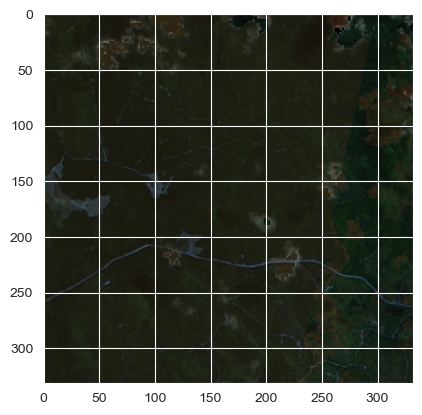

In [32]:
img = cv2.imread(train_df.example_path[0])
img_plot = plt.imshow(img)

In [33]:
img.shape

(332, 332, 3)

In [34]:
class Data_generator():
    """
    Data generator
    """
    def __init__(self, train_df, train_size, width, height, channels):
        self.train_df = train_df
        self.train_size = train_size
        self.width = width
        self.height = height
        self.channels = channels

    def generate_split_indexes(self):
        '''
        '''
        np.random.seed(1)
        permutation = np.random.permutation(len(self.train_df))
        index = int(len(self.train_df) * self.train_size)
        train_index = permutation[:index]
        test_index = permutation[index:]

        return train_index, test_index

    def read_image(self, filepath):

        img = cv2.imread(filepath)
        return img

    def normalize(self, img):
        """Normalize the volume"""
        norm = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        norm = norm.astype("float64")
        return img

    def resize_image(self, img):
        # Get current depth
        resized_image = cv2.resize(img, (self.width, self.height))
        return resized_image

    def preprocess_image(self, path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        # Read scan
        img = self.read_image(path)
        # Normalize
        img = self.normalize(img)
        img = self.resize_image(img)

        return img

    def generate_data(self, indexes, is_training, batch_size=32):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        # arrays to store our batched data
        images, text, labels = [], [], []
        while True:
            for index in indexes:
                row = self.train_df.iloc[index]

                img_path = row['example_path']
                images.append(self.preprocess_image(img_path))

                labels.append(to_categorical(row['label'], 3))
                text.append(row[['year']])

                if len(images) >= batch_size:
                    yield [[np.float64(images), np.float64(text)]], np.float64(labels)
                    images, text, labels = [], [], []

            if not is_training:
                break

In [46]:
train_size = 0.80
image_width = 240
image_height = 240
image_depth = 3

data_generator = Data_generator(train_df, train_size, image_width, image_height, image_depth)
train_index, valid_index = data_generator.generate_split_indexes()

In [47]:
def completar_modelo(modelo, input_text):
    rama_clasificacion = layers.Concatenate()([modelo, input_text])

    rama_clasificacion = layers.Dense(256, activation="relu")(rama_clasificacion)
    rama_clasificacion = layers.BatchNormalization()(rama_clasificacion)
    rama_clasificacion = layers.Dropout(0.5)(rama_clasificacion)
    rama_clasificacion = layers.Dense(512, activation="relu")(rama_clasificacion)
    rama_clasificacion = layers.Dense(3)(rama_clasificacion)
    rama_clasificacion = layers.Activation("softmax", name="grade")(rama_clasificacion)

    return rama_clasificacion

In [48]:
from keras.applications.densenet import DenseNet121

input_text = layers.Input(shape=(1))

base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(240,240,3))
base = base_model.output
base = layers.GlobalAveragePooling2D()(base)
rama_clasificacion = completar_modelo(base, input_text)

# Model to be trained
def_model = Model(inputs=[base_model.input, input_text], outputs=rama_clasificacion, name="deforestation_model")

# Training only top layers i.e. the layers which we have added in the end
for layer in base_model.layers:
    layer.trainable = False

In [49]:
epochs = 50
def_model.compile(optimizer=Adam(learning_rate=0.0002),
            loss="categorical_crossentropy",
            metrics = ['accuracy', f1_score]
)

batch_size = 32
train_batch_size =  batch_size
valid_batch_size = 32
train_gen = data_generator.generate_data(train_index, is_training=True, batch_size=train_batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, batch_size=valid_batch_size)

earylyStopping = EarlyStopping(monitor='val_f1_score', patience=10, restore_best_weights=True)
callbacks = [earylyStopping]

history = def_model.fit(train_gen,
                    steps_per_epoch=(len(train_index))//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=(len(valid_index))//valid_batch_size,
                    verbose=1)

Epoch 1/50


NotImplementedError: in user code:

    File "C:\Users\diego\anaconda3\envs\NSVM_nuwe_hackaton\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\diego\anaconda3\envs\NSVM_nuwe_hackaton\lib\site-packages\sklearn\metrics\_classification.py", line 1143, in f1_score  *
        zero_division=zero_division,
    File "C:\Users\diego\anaconda3\envs\NSVM_nuwe_hackaton\lib\site-packages\sklearn\metrics\_classification.py", line 1275, in fbeta_score  *
        _, _, f, _ = precision_recall_fscore_support(
    File "C:\Users\diego\anaconda3\envs\NSVM_nuwe_hackaton\lib\site-packages\sklearn\metrics\_classification.py", line 1558, in precision_recall_fscore_support  *
        labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
    File "C:\Users\diego\anaconda3\envs\NSVM_nuwe_hackaton\lib\site-packages\sklearn\metrics\_classification.py", line 1364, in _check_set_wise_labels  *
        y_type, y_true, y_pred = _check_targets(y_true, y_pred)
    File "C:\Users\diego\anaconda3\envs\NSVM_nuwe_hackaton\lib\site-packages\sklearn\metrics\_classification.py", line 84, in _check_targets  *
        check_consistent_length(y_true, y_pred)
    File "C:\Users\diego\anaconda3\envs\NSVM_nuwe_hackaton\lib\site-packages\sklearn\utils\validation.py", line 385, in check_consistent_length  *
        uniques = np.unique(lengths)
    File "<__array_function__ internals>", line 5, in unique  **
        
    File "C:\Users\diego\anaconda3\envs\NSVM_nuwe_hackaton\lib\site-packages\numpy\lib\arraysetops.py", line 270, in unique
        ar = np.asanyarray(ar)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (strided_slice_1:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.
